# 1. Forecast weather using SARIMA model



In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
weather = pd.read_csv("thai binh 2002-01-31 to 2004-10-26.csv", on_bad_lines='skip')
weather = weather[['datetime','temp', 'humidity', 'windspeed']]
weather = weather.dropna(subset=['temp'])
weather.dtypes

,0
datetime,object
temp,float64
humidity,float64
windspeed,float64


We need to group each month and take averages. Even though the initial plan was to make daily prediction using a SARIMA model, using 365 as seasonality parameter is too much for the model to reasonably work (even Google Colab Pro is not able to meet the RAM requirement and calculations require 1+ hour)

In [4]:
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.rename(columns={'temp': 'temperature', 'datetime': 'date'})
weather = weather.resample('M', on='date').mean()
weather.reset_index(inplace=True)
weather.head(2)

,date,temperature,humidity,windspeed
0,2002-01-31,15.70,84.300000,9.700000
1,2002-02-28,18.65,90.771429,12.067857


Text(0.5, 1.0, "Thai Binh's Monthly Averate Temperature Data")

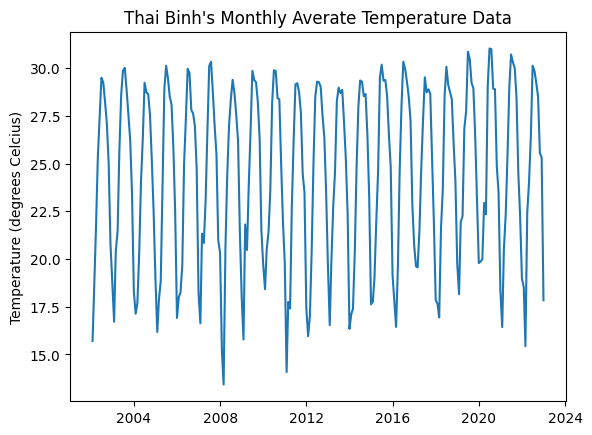

In [5]:
plt.plot(weather.set_index('date')['temperature'])
plt.ylabel('Temperature (degrees Celcius)')
plt.title("Thai Binh's Monthly Averate Temperature Data")

In [6]:
weather_seperated = weather.copy(deep=True)
weather_seperated = weather_seperated[['date', 'temperature']]
weather_seperated['year'] = weather_seperated['date'].dt.year
weather_seperated['month'] = weather_seperated['date'].dt.month
weather_seperated.drop(['date'], axis=1, inplace=True)
weather_seperated = weather_seperated.pivot_table(index='month',  columns='year', values='temperature')


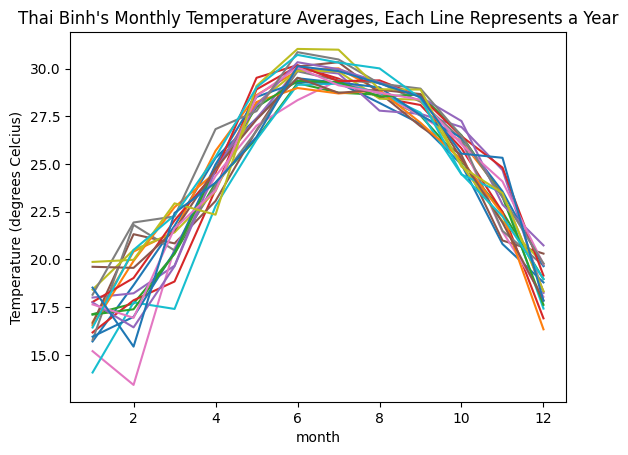

In [7]:
weather_seperated.plot()
plt.ylabel('Temperature (degrees Celcius)')
plt.title("Thai Binh's Monthly Temperature Averages, Each Line Represents a Year")
plt.legend().remove()
plt.show()

In [8]:
#Taking a deep copy of the weather DataFrame
weather_linear = weather.copy(deep=True)
weather_linear['month'] = pd.DatetimeIndex(weather_linear['date']).month

#One-hot-encoding of month data
weather_linear = pd.get_dummies(weather_linear, columns = ['month'])
weather_linear.head()

,date,temperature,humidity,windspeed,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2002-01-31,15.700000,84.300000,9.700000,True,False,False,False,False,False,False,False,False,False,False,False
1,2002-02-28,18.650000,90.771429,12.067857,False,True,False,False,False,False,False,False,False,False,False,False
2,2002-03-31,21.761290,87.706452,13.345161,False,False,True,False,False,False,False,False,False,False,False,False
3,2002-04-30,25.320000,87.206667,14.823333,False,False,False,True,False,False,False,False,False,False,False,False
4,2002-05-31,27.393548,85.793548,16.258065,False,False,False,False,True,False,False,False,False,False,False,False


In [9]:
def ad_fuller(timeseries):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(timeseries, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)

print(ad_fuller(weather['temperature']))

Dickey-Fuller Test indicates:
Test Statistic                  -4.334419
p-value                          0.002780
#Lags Used                      15.000000
Number of Observations Used    236.000000
dtype: float64
None


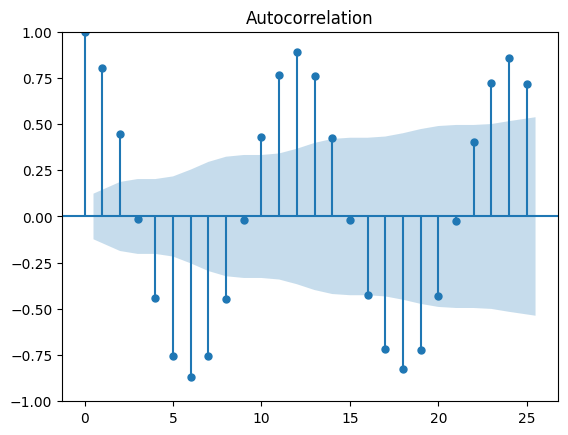

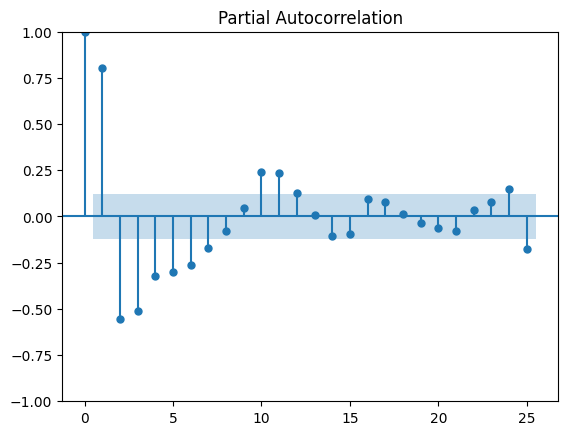

In [10]:
plot_acf(weather['temperature'])
plt.show()
plot_pacf(weather['temperature'])
plt.show()

In [12]:
train_data_SARIMA = weather[weather['date'] < '2015-01-31']
test_data_SARIMA = weather[weather['date'] >= '2015-01-31']
train_data_SARIMA.head(2)

,date,temperature,humidity,windspeed
0,2002-01-31,15.70,84.300000,9.700000
1,2002-02-28,18.65,90.771429,12.067857


In [13]:
model = sm.tsa.statespace.SARIMAX(train_data_SARIMA['temperature'],
                         order=(2, 0, 1),
                         seasonal_order=(0, 1, 1, 12))
result = model.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                  156
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -227.135
Date:                            Wed, 23 Oct 2024   AIC                            464.270
Time:                                    03:57:25   BIC                            479.119
Sample:                                         0   HQIC                           470.304
                                            - 156                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8150      0.708      1.151      0.250      -0.573       2.203
ar.L2         -0.0540      0.177   

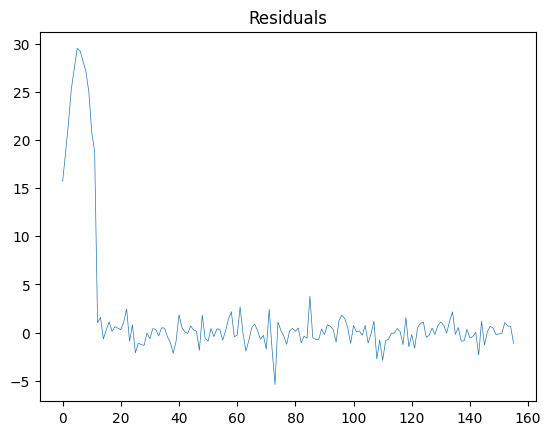

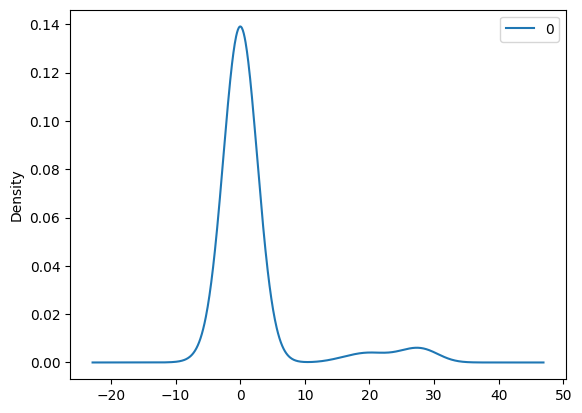

In [14]:
#Checking for obvious patterns in residuals. Any pattern is a bad sign.
residuals = pd.DataFrame(result.resid)
residuals.plot(linewidth=0.5, legend=None)
plt.title('Residuals')
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

Size of data is 1008 and train set size is 984


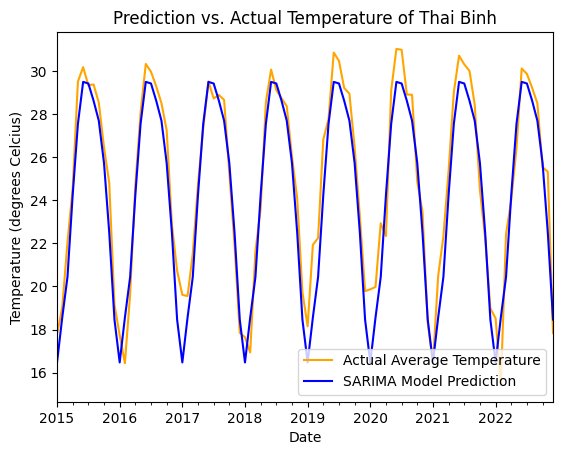

In [16]:
#Training the model again after each prediction, making one-step-ahead prediction each time
print(f'Size of data is {weather.size} and train set size is {weather.size-24}')
one_step_predictions = []
for i in range(96):
  cut_point = weather.size - 24 + i
  model = sm.tsa.statespace.SARIMAX(train_data_SARIMA['temperature'][:cut_point],
                         order=(1, 0, 1),
                         seasonal_order=(0, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
  result = model.fit()
  one_step_predictions.append(result.predict(cut_point).values[0])

test_data_SARIMA['prediction'] = one_step_predictions
test_data_SARIMA.set_index('date', inplace=True)
test_data_SARIMA['temperature'].plot(label='Actual Average Temperature', color='orange')
test_data_SARIMA['prediction'].plot(label='SARIMA Model Prediction', color='blue')
plt.title("Prediction vs. Actual Temperature of Thai Binh")
plt.xlabel('Date')
plt.ylabel('Temperature (degrees Celcius)')

plt.legend(loc='lower right')

In [17]:
test_data_SARIMA['SSRes'] = (test_data_SARIMA['temperature'] - test_data_SARIMA['prediction'])**2
mean_temp = test_data_SARIMA['temperature'].mean()
test_data_SARIMA['SSTot'] = (test_data_SARIMA['temperature'] - mean_temp)**2
r2_SARIMA = 1 - (test_data_SARIMA['SSRes'].sum() / test_data_SARIMA['SSTot'].sum())
print(f'Coefficient of determination: {r2_SARIMA:.3f}')

Coefficient of determination: 0.910


In [18]:
train_data_SARIMA

,date,temperature,humidity,windspeed
0,2002-01-31,15.700000,84.300000,9.700000
1,2002-02-28,18.650000,90.771429,12.067857
2,2002-03-31,21.761290,87.706452,13.345161
3,2002-04-30,25.320000,87.206667,14.823333
4,2002-05-31,27.393548,85.793548,16.258065
...,...,...,...,...
151,2014-08-31,28.535484,85.535484,20.922581
152,2014-09-30,28.643333,82.133333,18.793333
153,2014-10-31,26.503226,78.058065,18.409677
154,2014-11-30,23.276667,84.826667,20.413333


In [19]:
test_data_SARIMA.reset_index(inplace=True)
test_data_SARIMA

,date,temperature,humidity,windspeed,prediction,SSRes,SSTot
0,2015-01-31,17.767742,82.638710,21.158065,16.472067,1.678775,49.828388
1,2015-02-28,19.025000,87.692857,20.053571,18.557138,0.218895,33.659311
2,2015-03-31,22.041935,90.783871,20.551613,20.440402,2.564908,7.754716
3,2015-04-30,24.573333,83.543333,23.100000,24.252887,0.102686,0.064177
4,2015-05-31,29.519355,83.148387,23.825806,27.549188,3.881558,22.021343
...,...,...,...,...,...,...,...
91,2022-08-31,29.225806,85.238710,18.887097,28.626305,0.359402,19.352450
92,2022-09-30,28.510000,82.823333,16.390000,27.699687,0.656606,13.566960
93,2022-10-31,25.545161,72.370968,18.441935,25.728409,0.033580,0.516238
94,2022-11-30,25.326667,80.836667,16.810000,22.504007,7.967406,0.250002


# 2. Predict crop production with LSTM

In [20]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [21]:
data = pd.read_excel('ThaiBinh.xlsx')
data

,Unnamed: 0,Cả năm,Unnamed: 2,Vụ đông xuân,Unnamed: 4,Vụ mùa,Unnamed: 6
0,Năm,Năng suất (Tạ/ha),Sản lượng (Nghìn tấn),Năng suất (Tạ/ha),Sản lượng (Nghìn tấn),Năng suất (Tạ/ha),Sản lượng (Nghìn tấn)
1,2002,63,1081.6,67.4,574.1,58.6,507.5
2,2003,54.6,930.7,69.2,585.8,40.2,344.9
3,2004,63.4,1069.5,70.2,585.4,56.8,484.1
4,2005,58.6,981.6,71.1,590.1,46.4,391.5
5,2006,65,1079.6,71.1,584.1,59.1,495.5
6,2007,61.5,1014.8,61,498.6,62,516.2
7,2008,65.7,1105.2,70,589.4,62,515.8
8,2009,66.2,1105.8,70.3,585.3,62,520.5
9,2010,66.4,1104.4,70.6,583.7,62.2,520.7


In [22]:
# Load crop data
data.columns = ['Year', 'Full_year_yield', 'Full_year_production', 'Winter_Spring_yield', 'Winter_Spring_production', 'Summer_yield', 'Summer_production']
data_cleaned = data.drop(0)
data_cleaned['Year'] = pd.to_numeric(data_cleaned['Year'])
data_cleaned = data_cleaned.dropna()

In [23]:
# Selecting the 'Year' and 'Full_year_production' as key variables
key_data = data_cleaned[['Year', 'Full_year_production']].dropna()

In [24]:
key_data

,Year,Full_year_production
1,2002,1081.6
2,2003,930.7
3,2004,1069.5
4,2005,981.6
5,2006,1079.6
6,2007,1014.8
7,2008,1105.2
8,2009,1105.8
9,2010,1104.4
10,2011,1091.3


In [25]:
train_data_SARIMA['date'] = pd.to_datetime(train_data_SARIMA['date'])
train_data_SARIMA['Year'] = train_data_SARIMA['date'].dt.year

test_data_SARIMA['date'] = pd.to_datetime(test_data_SARIMA['date'])
test_data_SARIMA['Year'] = test_data_SARIMA['date'].dt.year

In [26]:
test_data_SARIMA

,date,temperature,humidity,windspeed,prediction,SSRes,SSTot,Year
0,2015-01-31,17.767742,82.638710,21.158065,16.472067,1.678775,49.828388,2015
1,2015-02-28,19.025000,87.692857,20.053571,18.557138,0.218895,33.659311,2015
2,2015-03-31,22.041935,90.783871,20.551613,20.440402,2.564908,7.754716,2015
3,2015-04-30,24.573333,83.543333,23.100000,24.252887,0.102686,0.064177,2015
4,2015-05-31,29.519355,83.148387,23.825806,27.549188,3.881558,22.021343,2015
...,...,...,...,...,...,...,...,...
91,2022-08-31,29.225806,85.238710,18.887097,28.626305,0.359402,19.352450,2022
92,2022-09-30,28.510000,82.823333,16.390000,27.699687,0.656606,13.566960,2022
93,2022-10-31,25.545161,72.370968,18.441935,25.728409,0.033580,0.516238,2022
94,2022-11-30,25.326667,80.836667,16.810000,22.504007,7.967406,0.250002,2022


In [27]:
train_data_yearly = train_data_SARIMA.groupby('Year').agg(
    temperature=('temperature', 'mean'),
    humidity=('humidity', 'mean'),
    windspeed=('windspeed', 'mean')
).reset_index()

test_data_yearly = test_data_SARIMA.groupby('Year').agg(
    temperature=('temperature', 'mean'),
    humidity=('humidity', 'mean'),
    windspeed=('windspeed', 'mean'),
    prediction=('prediction', 'mean')
).reset_index()

In [28]:
test_data_yearly

,Year,temperature,humidity,windspeed,prediction
0,2015,25.067173,83.301905,21.671552,24.10203
1,2016,24.629837,81.977689,19.760818,24.10203
2,2017,24.469717,82.634969,16.733751,24.10203
3,2018,24.545566,81.477426,18.065410,24.10203
4,2019,25.496256,82.952869,17.942835,24.10203
5,2020,25.062138,80.558840,18.188062,24.10203
6,2021,24.903188,80.956586,17.444170,24.10203
7,2022,24.439442,81.177378,16.929429,24.10203


In [29]:
# Combine both train and test weather forecasts into a single dataframe
full_weather_data = pd.concat([
    train_data_yearly[['Year', 'temperature']],
    test_data_yearly[['Year', 'prediction']].rename(columns={'prediction': 'temperature'})
], axis=0).reset_index(drop=True)

In [30]:
# Merge weather data with crop production data
merged_data = pd.merge(
    data_cleaned[['Year', 'Full_year_production']],
    full_weather_data,
    on='Year',
    how='inner'
)

In [31]:
merged_data

,Year,Full_year_production,temperature
0,2002,1081.6,23.954776
1,2003,930.7,24.761690
2,2004,1069.5,23.851234
3,2005,981.6,23.903875
4,2006,1079.6,24.436222
5,2007,1014.8,24.295997
6,2008,1105.2,23.351818
7,2009,1105.8,24.409767
8,2010,1104.4,24.614622
9,2011,1091.3,23.204478


In [32]:
# Step 2: Scale the data (crop production and temperature)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data[['Full_year_production', 'temperature']])

In [46]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [34]:
X = merged_data[['temperature']].values  # Temperature as the feature
y = merged_data['Full_year_production'].values  # Crop production as the target

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [57]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [58]:
y_pred = model.predict(X_test)

In [59]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [60]:
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 7254.72
Mean Absolute Error: 66.51
R^2 Score: -0.46


In [61]:
predictions = model.predict(X)
print("Predicted Crop Production:", predictions)

Predicted Crop Production: [1006.314875   1084.072      1047.627875   1006.314875   1084.072
 1036.266      1095.01075    1094.552      1084.072      1089.31175
 1051.911      1039.7520417  1049.687      1024.24422146 1024.24422146
 1024.24422146 1024.24422146 1024.24422146 1024.24422146 1024.24422146
 1024.24422146]


In [62]:
# Step 8: Perform Grid Search for Hyperparameter Tuning (Optional)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [63]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


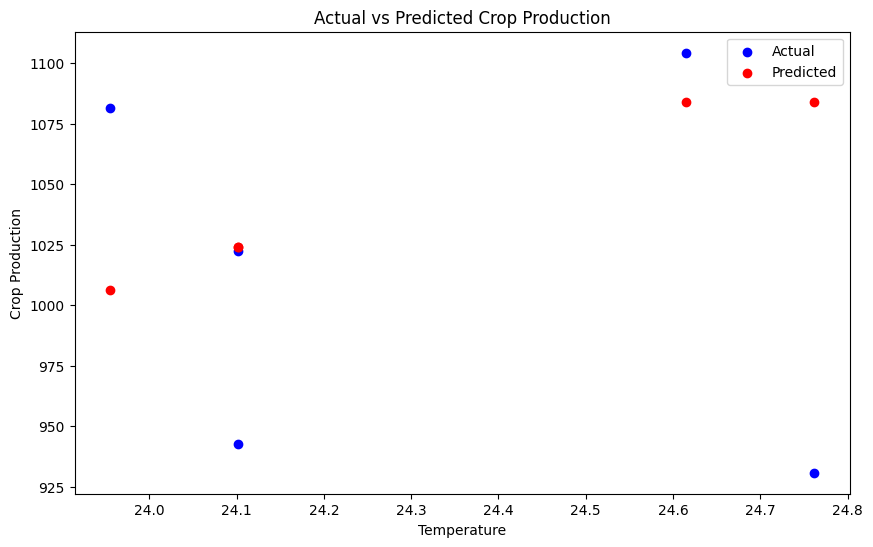

In [64]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('Temperature')
plt.ylabel('Crop Production')
plt.title('Actual vs Predicted Crop Production')
plt.legend()
plt.show()